# 1. Import required packages

In [1]:
%%capture
!pip install timm
!pip install randaugment

In [2]:
import os
import PIL
import time
import timm
import math
import copy
import torch
import torchvision
import itertools
import numpy as np
%matplotlib inline
import torch.nn as nn
from PIL import Image
from copy import deepcopy
import torch.optim as optim
import matplotlib.pyplot as plt
from timm.models.layers.activations import *
from collections import OrderedDict
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from timm.loss import LabelSmoothingCrossEntropy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from randaugment import RandAugment, ImageNetPolicy, Cutout
from tqdm import tqdm

# 2. Dataloader

In [3]:
# Hyperparameters
BATCH_SIZE = 16
NUM_EPOCHS = 50

In [4]:
root_dir = '/kaggle/input/chest-xray-classification'
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        Cutout(size=16),
        RandAugment(),
        ImageNetPolicy(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [5]:
image_datasets = {x : datasets.ImageFolder(os.path.join(root_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
data_loader = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE if x!='test' else 2, shuffle=True, num_workers=2, pin_memory=True) for x in ['train', 'val', 'test']}
dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print('Dataset size: ', dataset_sizes)
print('Class names: ', class_names)

Dataset size:  {'train': 17813, 'val': 2227, 'test': 2229}
Class names:  ['COVID', 'Lung_Opacity', 'Normal', 'Pneunomia', 'Tuberculosis']


# 3. ResNeXt101

In [6]:
model = timm.create_model('resnext101_32x8d', pretrained=True)
model.fc

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


Linear(in_features=2048, out_features=1000, bias=True)

In [7]:
from collections import OrderedDict

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 1024)),
    ('relu1', nn.ReLU(inplace=True)),
    ('fc2', nn.Linear(1024, 256)),
    ('relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(256, 5))
]))

model.fc = fc
model = model.to(device)

### Count model params
for params in model.parameters():
    params.requires_grad = True

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("ResNeXt101-32x8d parameters: ", count_params(model))

ResNeXt101-32x8d parameters:  89104197


# 4. Training model

In [8]:
criterion = LabelSmoothingCrossEntropy()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS , path='model.pth'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = math.inf
    best_acc = 0.

    train_log = {'loss': [],
                 'acc': []}
    val_log = {'loss': [],
              'acc': []}
    
    for epoch in range(num_epochs):
        
        print('-'*5, f'Epoch {epoch+1}/{num_epochs}', '-'*5)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_correct = 0
            
            for i, (inputs, labels) in tqdm(enumerate(data_loader[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item()*inputs.size(0)
                running_correct += torch.sum(preds==labels.data).item()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_correct / dataset_sizes[phase]
            print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                scheduler.step()
                train_log['loss'].append(epoch_loss)
                train_log['acc'].append(epoch_acc)
            else:
                val_log['loss'].append(epoch_loss)
                val_log['acc'].append(epoch_acc)
                
            if phase == 'val' and epoch_acc > best_acc:
                print(f'New acc: {epoch_acc:.4f}, previous acc: {best_acc:.4f}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path)
                
    time_elapsed = time.time()-since
    print('Training complete in: {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))
    
    model.load_state_dict(best_model_wts)
    return model, train_log, val_log

In [10]:
model, train_log, val_log = train_model(model, criterion, optimizer, scheduler)

----- Epoch 1/50 -----


1114it [07:55,  2.35it/s]

train loss: 1.0532 acc: 0.6541



140it [00:29,  4.74it/s]


val loss: 0.7519 acc: 0.8177
New acc: 0.8177, previous acc: 0.0000
----- Epoch 2/50 -----


1114it [07:48,  2.38it/s]

train loss: 0.9180 acc: 0.7283



140it [00:24,  5.62it/s]

val loss: 0.9015 acc: 0.7970
----- Epoch 3/50 -----



1114it [07:44,  2.40it/s]

train loss: 0.8734 acc: 0.7525



140it [00:25,  5.54it/s]


val loss: 0.7031 acc: 0.8572
New acc: 0.8572, previous acc: 0.8177
----- Epoch 4/50 -----


1114it [07:47,  2.38it/s]

train loss: 0.8468 acc: 0.7656



140it [00:26,  5.38it/s]

val loss: 0.6785 acc: 0.8563
----- Epoch 5/50 -----



1114it [07:52,  2.36it/s]

train loss: 0.8176 acc: 0.7807



140it [00:26,  5.26it/s]


val loss: 0.6913 acc: 0.8662
New acc: 0.8662, previous acc: 0.8572
----- Epoch 6/50 -----


1114it [07:52,  2.36it/s]

train loss: 0.8060 acc: 0.7885



140it [00:26,  5.32it/s]


val loss: 0.6168 acc: 0.8927
New acc: 0.8927, previous acc: 0.8662
----- Epoch 7/50 -----


1114it [07:49,  2.37it/s]

train loss: 0.7920 acc: 0.7931



140it [00:25,  5.58it/s]

val loss: 0.6403 acc: 0.8824
----- Epoch 8/50 -----



1114it [07:50,  2.37it/s]

train loss: 0.7740 acc: 0.8036



140it [00:26,  5.19it/s]

val loss: 0.7025 acc: 0.8550
----- Epoch 9/50 -----



1114it [07:50,  2.37it/s]

train loss: 0.7618 acc: 0.8113



140it [00:27,  5.14it/s]


val loss: 0.5768 acc: 0.9138
New acc: 0.9138, previous acc: 0.8927
----- Epoch 10/50 -----


1114it [07:43,  2.40it/s]

train loss: 0.7568 acc: 0.8114



140it [00:27,  5.03it/s]

val loss: 0.6326 acc: 0.8801
----- Epoch 11/50 -----



1114it [07:48,  2.38it/s]

train loss: 0.6979 acc: 0.8442



140it [00:28,  4.91it/s]

val loss: 0.6090 acc: 0.9039
----- Epoch 12/50 -----



1114it [07:48,  2.38it/s]

train loss: 0.6887 acc: 0.8517



140it [00:25,  5.44it/s]


val loss: 0.5639 acc: 0.9201
New acc: 0.9201, previous acc: 0.9138
----- Epoch 13/50 -----


1114it [07:51,  2.36it/s]

train loss: 0.6779 acc: 0.8529



140it [00:24,  5.62it/s]

val loss: 0.5648 acc: 0.9178
----- Epoch 14/50 -----



1114it [07:48,  2.38it/s]

train loss: 0.6751 acc: 0.8559



140it [00:25,  5.56it/s]

val loss: 0.6041 acc: 0.9017
----- Epoch 15/50 -----



1114it [07:47,  2.38it/s]

train loss: 0.6672 acc: 0.8581



140it [00:25,  5.50it/s]


val loss: 0.5504 acc: 0.9223
New acc: 0.9223, previous acc: 0.9201
----- Epoch 16/50 -----


1114it [07:47,  2.38it/s]

train loss: 0.6685 acc: 0.8572



140it [00:25,  5.57it/s]


val loss: 0.5467 acc: 0.9246
New acc: 0.9246, previous acc: 0.9223
----- Epoch 17/50 -----


1114it [07:55,  2.34it/s]

train loss: 0.6664 acc: 0.8606



140it [00:25,  5.41it/s]

val loss: 0.6097 acc: 0.9012
----- Epoch 18/50 -----



1114it [07:50,  2.37it/s]

train loss: 0.6625 acc: 0.8613



140it [00:27,  5.05it/s]

val loss: 0.5818 acc: 0.9124
----- Epoch 19/50 -----



1114it [07:51,  2.36it/s]

train loss: 0.6613 acc: 0.8645



140it [00:25,  5.51it/s]

val loss: 0.5679 acc: 0.9205
----- Epoch 20/50 -----



1114it [07:51,  2.36it/s]

train loss: 0.6617 acc: 0.8623



140it [00:30,  4.66it/s]

val loss: 0.5501 acc: 0.9223
----- Epoch 21/50 -----



1114it [07:48,  2.38it/s]

train loss: 0.6271 acc: 0.8809



140it [00:24,  5.64it/s]


val loss: 0.5231 acc: 0.9380
New acc: 0.9380, previous acc: 0.9246
----- Epoch 22/50 -----


1114it [07:53,  2.35it/s]

train loss: 0.6148 acc: 0.8874



140it [00:26,  5.20it/s]


val loss: 0.5324 acc: 0.9385
New acc: 0.9385, previous acc: 0.9380
----- Epoch 23/50 -----


1114it [07:57,  2.33it/s]

train loss: 0.6124 acc: 0.8879



140it [00:24,  5.61it/s]


val loss: 0.5168 acc: 0.9403
New acc: 0.9403, previous acc: 0.9385
----- Epoch 24/50 -----


1114it [07:50,  2.37it/s]

train loss: 0.6112 acc: 0.8876



140it [00:25,  5.51it/s]

val loss: 0.5211 acc: 0.9403
----- Epoch 25/50 -----



1114it [07:51,  2.36it/s]

train loss: 0.6105 acc: 0.8865



140it [00:28,  4.87it/s]


val loss: 0.5124 acc: 0.9407
New acc: 0.9407, previous acc: 0.9403
----- Epoch 26/50 -----


1114it [07:51,  2.36it/s]

train loss: 0.6064 acc: 0.8917



140it [00:25,  5.52it/s]

val loss: 0.5502 acc: 0.9282
----- Epoch 27/50 -----



1114it [07:50,  2.37it/s]

train loss: 0.6033 acc: 0.8921



140it [00:26,  5.36it/s]


val loss: 0.5040 acc: 0.9448
New acc: 0.9448, previous acc: 0.9407
----- Epoch 28/50 -----


1114it [07:51,  2.36it/s]

train loss: 0.6026 acc: 0.8927



140it [00:25,  5.59it/s]

val loss: 0.5127 acc: 0.9385
----- Epoch 29/50 -----



1114it [07:46,  2.39it/s]

train loss: 0.5995 acc: 0.8937



140it [00:24,  5.73it/s]

val loss: 0.5062 acc: 0.9439
----- Epoch 30/50 -----



1114it [07:50,  2.37it/s]

train loss: 0.6012 acc: 0.8924



140it [00:32,  4.25it/s]


val loss: 0.5138 acc: 0.9461
New acc: 0.9461, previous acc: 0.9448
----- Epoch 31/50 -----


1114it [07:45,  2.39it/s]

train loss: 0.5832 acc: 0.9005



140it [00:24,  5.67it/s]

val loss: 0.5128 acc: 0.9385
----- Epoch 32/50 -----



1114it [07:47,  2.38it/s]

train loss: 0.5785 acc: 0.9054



140it [00:24,  5.62it/s]


val loss: 0.5083 acc: 0.9493
New acc: 0.9493, previous acc: 0.9461
----- Epoch 33/50 -----


1114it [07:50,  2.37it/s]

train loss: 0.5748 acc: 0.9067



140it [00:24,  5.68it/s]

val loss: 0.5048 acc: 0.9493
----- Epoch 34/50 -----



1114it [07:48,  2.38it/s]

train loss: 0.5700 acc: 0.9087



140it [00:24,  5.62it/s]

val loss: 0.5071 acc: 0.9407
----- Epoch 35/50 -----



1114it [07:49,  2.37it/s]

train loss: 0.5651 acc: 0.9119



140it [00:30,  4.53it/s]


val loss: 0.5019 acc: 0.9502
New acc: 0.9502, previous acc: 0.9493
----- Epoch 36/50 -----


1114it [07:48,  2.38it/s]

train loss: 0.5714 acc: 0.9080



140it [00:25,  5.54it/s]

val loss: 0.5104 acc: 0.9434
----- Epoch 37/50 -----



1114it [07:50,  2.37it/s]

train loss: 0.5659 acc: 0.9106



140it [00:24,  5.72it/s]

val loss: 0.5099 acc: 0.9434
----- Epoch 38/50 -----



1114it [07:50,  2.37it/s]

train loss: 0.5655 acc: 0.9115



140it [00:25,  5.55it/s]

val loss: 0.5139 acc: 0.9425
----- Epoch 39/50 -----



1114it [07:49,  2.37it/s]

train loss: 0.5677 acc: 0.9093



140it [00:30,  4.60it/s]

val loss: 0.5144 acc: 0.9416
----- Epoch 40/50 -----



1114it [07:45,  2.39it/s]

train loss: 0.5651 acc: 0.9114



140it [00:25,  5.58it/s]

val loss: 0.5230 acc: 0.9385
----- Epoch 41/50 -----



1114it [07:57,  2.33it/s]

train loss: 0.5518 acc: 0.9181



140it [00:25,  5.53it/s]


val loss: 0.4970 acc: 0.9542
New acc: 0.9542, previous acc: 0.9502
----- Epoch 42/50 -----


1114it [07:51,  2.36it/s]

train loss: 0.5528 acc: 0.9183



140it [00:24,  5.75it/s]

val loss: 0.4966 acc: 0.9497
----- Epoch 43/50 -----



1114it [07:52,  2.36it/s]

train loss: 0.5500 acc: 0.9199



140it [00:32,  4.29it/s]

val loss: 0.5024 acc: 0.9520
----- Epoch 44/50 -----



1114it [07:48,  2.38it/s]

train loss: 0.5505 acc: 0.9213



140it [00:25,  5.59it/s]

val loss: 0.4976 acc: 0.9497
----- Epoch 45/50 -----



1114it [07:55,  2.34it/s]

train loss: 0.5459 acc: 0.9227



140it [00:25,  5.48it/s]

val loss: 0.5076 acc: 0.9466
----- Epoch 46/50 -----



1114it [07:52,  2.36it/s]

train loss: 0.5442 acc: 0.9239



140it [00:24,  5.73it/s]

val loss: 0.4977 acc: 0.9484
----- Epoch 47/50 -----



1114it [07:49,  2.37it/s]

train loss: 0.5436 acc: 0.9231



140it [00:26,  5.21it/s]

val loss: 0.5036 acc: 0.9479
----- Epoch 48/50 -----



1114it [07:53,  2.35it/s]

train loss: 0.5408 acc: 0.9253



140it [00:25,  5.58it/s]

val loss: 0.4990 acc: 0.9488
----- Epoch 49/50 -----



1114it [07:56,  2.34it/s]

train loss: 0.5411 acc: 0.9238



140it [00:24,  5.69it/s]

val loss: 0.4942 acc: 0.9533
----- Epoch 50/50 -----



1114it [07:49,  2.37it/s]

train loss: 0.5425 acc: 0.9228



140it [00:33,  4.23it/s]

val loss: 0.5109 acc: 0.9443
Training complete in: 414m 28s
Best val acc: 0.9542 Best val loss: 0.4970


# 5. Plot loss and accuracy

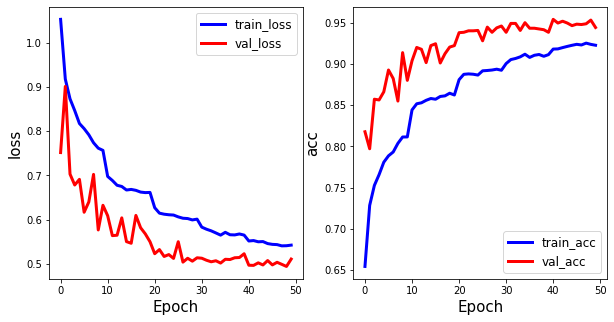

In [11]:
def plot_model_history(train_log, val_log, num_epochs):
    n = len(train_log)
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 5))
    plt.title("Training progress", fontsize=15)
    for i, k in enumerate(train_log.keys()):       
        plt.subplot(n//2, 2, i+1)
        plt.plot(x, train_log[k], label=f'train_{k}', lw=3, c="b")
        plt.plot(x, val_log[k], label=f'val_{k}', lw=3, c="r")
        plt.legend(fontsize=12)
        plt.xlabel("Epoch", fontsize=15)
        plt.ylabel(f"{k}", fontsize=15)
    plt.show()
    
plot_model_history(train_log, val_log, NUM_EPOCHS)

# 6. Prediction on Test set

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
# model = timm.create_model('resnext101_32x8d', pretrained=True)
# fc = nn.Sequential(OrderedDict([
#     ('fc1', nn.Linear(2048, 1024)),
#     ('relu1', nn.ReLU(inplace=True)),
#     ('fc2', nn.Linear(1024, 256)),
#     ('relu2', nn.ReLU(inplace=True)),
#     ('fc3', nn.Linear(256, 5))
# ]))

# model.fc = fc
# model = model.to(device)

model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

Testing complete in 0m 45s
              precision    recall  f1-score   support

           0    0.98551   0.93923   0.96181       362
           1    0.95509   0.91860   0.93649       602
           2    0.93327   0.97642   0.95436      1060
           3    0.97674   0.93333   0.95455       135
           4    0.98507   0.94286   0.96350        70

    accuracy                        0.95110      2229
   macro avg    0.96714   0.94209   0.95414      2229
weighted avg    0.95191   0.95110   0.95104      2229



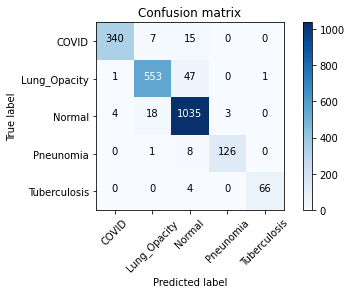

In [14]:
since = time.time()
model.eval()
y_test = []
y_pred = []
y_pred_proba = []
for images, labels in data_loader['test']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    y_pred_proba.append(outputs.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
y_pred_proba = np.concatenate(y_pred_proba)
time_elapsed = time.time() - since

print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

confusion_mtx = confusion_matrix(y_test, y_pred)
# plot the confusion matrix
plot_labels = ['COVID', 'Lung_Opacity', 'Normal', 'Pneunomia', 'Tuberculosis']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_test, y_pred, digits=5)
print(report)

In [15]:
def softmax(vec):
    exponential = np.exp(vec)
    probabilities = exponential / np.sum(exponential)
    return probabilities

y_pred_proba = np.array([list(softmax(i)) for i in y_pred_proba])

ROC curve (area = 0.9948)


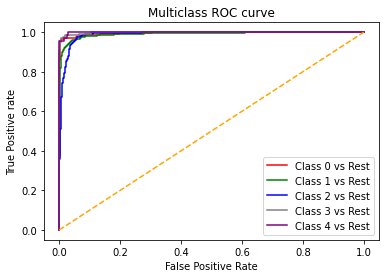

In [16]:
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
print('ROC curve (area = %0.4f)' % roc_auc)
fpr = {}
tpr = {}
thresh ={}
for i in range(5):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], color='gray', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], color='purple', label='Class 4 vs Rest')
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 